colab link
https://colab.research.google.com/drive/1X14HBXTfavyvuZzXZn9GUlcqLTKipU64?usp=sharing



In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [90]:
# Load GlobalTemperatures.csv
global_temp = pd.read_csv('/content/GlobalTemperatures.csv', parse_dates=['dt'])

# Load GlobalLandTemperaturesByCountry.csv
country_temp = pd.read_csv('/content/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])

# Load GlobalLandTemperaturesByState.csv
state_temp = pd.read_csv('/content/GlobalLandTemperaturesByState.csv', parse_dates=['dt'])


In [91]:
global_temp.set_index('dt', inplace=True)
# country_temp.set_index('dt', inplace=True)
# state_temp.set_index('dt', inplace=True)


In [92]:
global_temp.head()

,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,LandAverageTemperature
dt,,,,,,,,
1750-01-01,3.574,NaN,NaN,NaN,NaN,NaN,NaN,3.034
1750-02-01,3.702,NaN,NaN,NaN,NaN,NaN,NaN,3.083
1750-03-01,3.076,NaN,NaN,NaN,NaN,NaN,NaN,5.626
1750-04-01,2.451,NaN,NaN,NaN,NaN,NaN,NaN,8.490
1750-05-01,2.072,NaN,NaN,NaN,NaN,NaN,NaN,11.573


In [93]:
# Generate a complete monthly date range (MS means Month Start)
full_range = pd.date_range(start=global_temp.index.min(), end=global_temp.index.max(), freq='MS')


In [94]:
print(full_range)

DatetimeIndex(['1750-01-01', '1750-02-01', '1750-03-01', '1750-04-01',
               '1750-05-01', '1750-06-01', '1750-07-01', '1750-08-01',
               '1750-09-01', '1750-10-01',
               ...
               '2009-11-01', '2009-12-01', '2010-01-01', '2010-02-01',
               '2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01'],
              dtype='datetime64[ns]', length=3128, freq='MS')


In [95]:
# Reindex the DataFrame to include all months
global_temp = global_temp.reindex(full_range)

# Check how many missing timestamps we have
missing_dates = global_temp['LandAverageTemperature'].isna().sum()
print("Number of missing monthly entries:", missing_dates)

Number of missing monthly entries: 12


In [96]:
# Fill missing temperature values using time-based linear interpolation
global_temp['LandAverageTemperature'] = global_temp['LandAverageTemperature'].interpolate(method='time')


In [97]:
# Check how many missing timestamps we have
missing_dates = global_temp['LandAverageTemperature'].isna().sum()
print("Number of missing monthly entries:", missing_dates)


Number of missing monthly entries: 0


In [98]:
def reindex_and_impute_country(group, value_col='AverageTemperature'):
    # Set the date column as the index
    group = group.set_index('dt')
    # Create a full monthly date range (MS = Month Start)
    full_index = pd.date_range(start=group.index.min(), end=group.index.max(), freq='MS')
    # Reindex the group to ensure all months are present
    group = group.reindex(full_index)
    # Interpolate missing temperature values using time interpolation
    group[value_col] = group[value_col].interpolate(method='time')
    # Use forward/backward fill for any remaining missing values (e.g., at the edges)
    group[value_col] = group[value_col].ffill().bfill()
    # Reintroduce the Country information (all rows in the group have the same country)
    group['Country'] = group['Country'].iloc[0]
    # Reset the index to bring dt back as a column
    return group.reset_index().rename(columns={'index': 'dt'})


In [99]:
country_temp_imputed = country_temp.groupby('Country').apply(reindex_and_impute_country).reset_index(drop=True)


<ipython-input-99-e3fb0325aac1>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_temp_imputed = country_temp.groupby('Country').apply(reindex_and_impute_country).reset_index(drop=True)


In [100]:
def reindex_and_impute_state(group, value_col='AverageTemperature'):
    group = group.set_index('dt')
    full_index = pd.date_range(start=group.index.min(), end=group.index.max(), freq='MS')
    group = group.reindex(full_index)
    group[value_col] = group[value_col].interpolate(method='time')
    group[value_col] = group[value_col].ffill().bfill()
    # Restore the Country and State information for each row
    group['Country'] = group['Country'].iloc[0]
    group['State'] = group['State'].iloc[0]
    return group.reset_index().rename(columns={'index': 'dt'})


In [101]:
state_temp_imputed = state_temp.groupby(['Country', 'State']).apply(reindex_and_impute_state).reset_index(drop=True)


<ipython-input-101-81214612baac>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_temp_imputed = state_temp.groupby(['Country', 'State']).apply(reindex_and_impute_state).reset_index(drop=True)


In [102]:
def check_date_gaps(group):
    # Calculate the differences in days between consecutive dates
    gaps = group['dt'].diff().dt.days.dropna()

    return gaps

# # Apply to a sample country or loop over countries:
# sample_country = country_temp_imputed[country_temp_imputed['Country'] == 'United States']
gaps_sample = check_date_gaps(country_temp_imputed)
print(gaps_sample)


1         30.0
2         31.0
3         30.0
4         31.0
5         31.0
          ... 
568466    31.0
568467    30.0
568468    31.0
568469    30.0
568470    31.0
Name: dt, Length: 568470, dtype: float64


In [103]:
def check_date_gaps_state(group):
    group['dt'] = pd.to_datetime(group['dt'])
    return group['dt'].diff().dt.days.dropna()

# Loop over each country-state pair:
missing_gaps_state = {}
for (country, state), group in state_temp_imputed.groupby(['Country', 'State']):
    gaps = check_date_gaps_state(group)
    if not ((gaps >= 28) & (gaps <= 31)).all():
        missing_gaps_state[(country, state)] = gaps.unique()

print("Country-State pairs with abnormal date gaps:")
print(missing_gaps_state)


Country-State pairs with abnormal date gaps:
{}


In [104]:
missing_gaps = {}
for country, group in country_temp_imputed.groupby('Country'):
    group['dt'] = pd.to_datetime(group['dt'])
    gaps = group['dt'].diff().dt.days.dropna()
    #Flag if any gap is not within an acceptable range (for monthly data, expect ~28 to 31 days)
    if not ((gaps >= 28) & (gaps <= 31)).all():
        missing_gaps[country] = gaps.unique()

print("Countries with abnormal date gaps:")
print(missing_gaps)


Countries with abnormal date gaps:
{}


In [105]:
# Define the land fraction and ocean fraction to enable us find ocean average temprature seperately
alpha = 0.29
ocean_fraction = 1 - alpha  # ~0.71

In [106]:

# Derive the Ocean Average Temperature using the weighted average formula
global_temp['OceanAverageTemperature'] = (global_temp['LandAndOceanAverageTemperature'] - alpha * global_temp['LandAverageTemperature']) / ocean_fraction

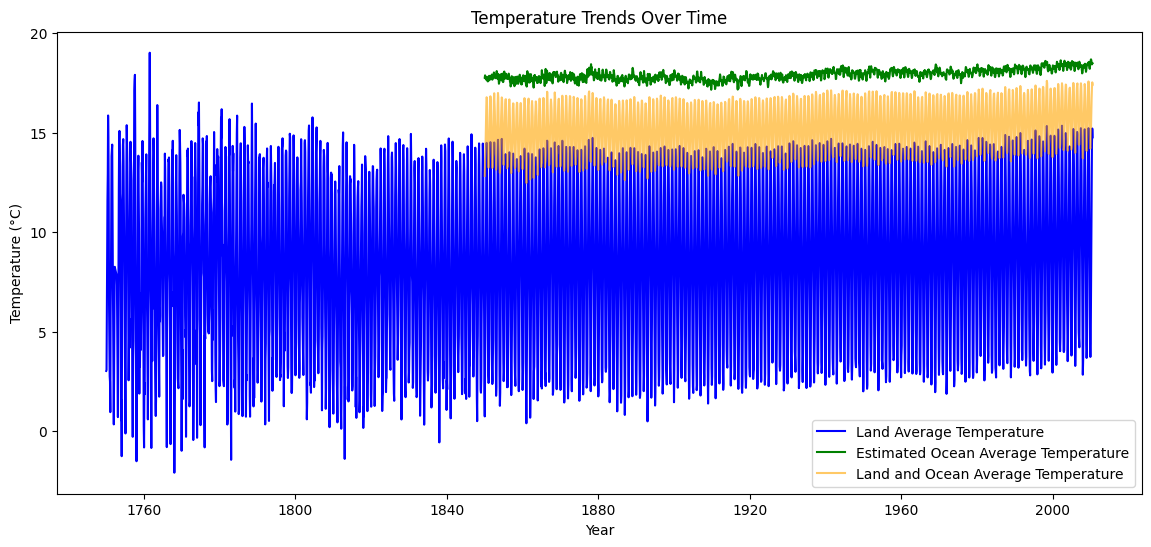

In [107]:
# Plot the temperatures to visualize the trends
plt.figure(figsize=(14,6))
plt.plot(global_temp.index, global_temp['LandAverageTemperature'], label='Land Average Temperature', color='blue')
plt.plot(global_temp.index, global_temp['OceanAverageTemperature'], label='Estimated Ocean Average Temperature', color='green')
plt.plot(global_temp.index, global_temp['LandAndOceanAverageTemperature'], label='Land and Ocean Average Temperature', color='orange', alpha=0.6)
plt.title('Temperature Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

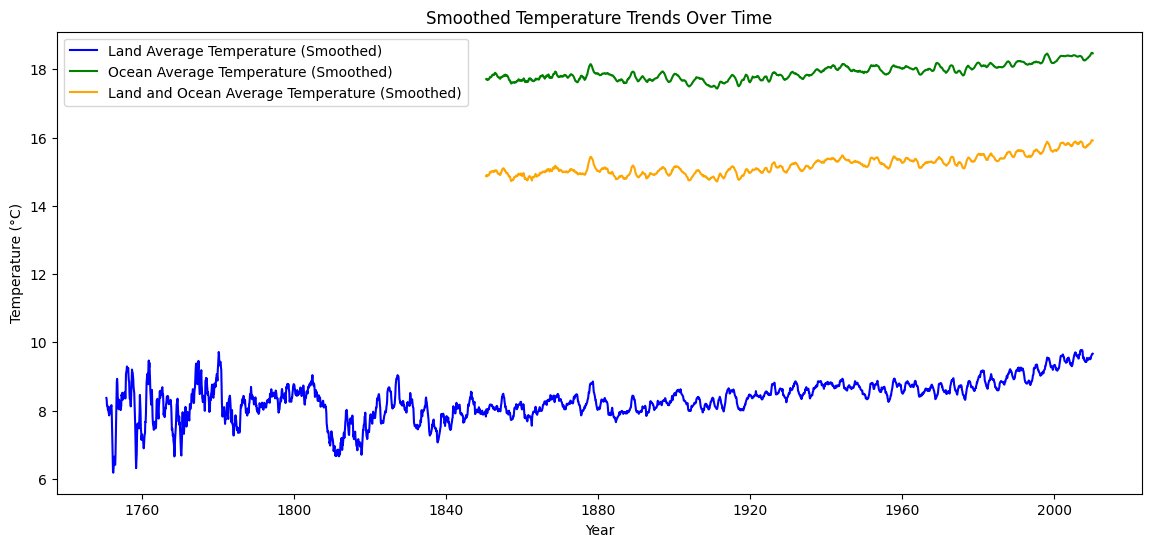

In [108]:


# Apply a 12-month rolling average to each temperature series
global_temp['LandAverageTemperature_Smoothed'] = global_temp['LandAverageTemperature'].rolling(window=12, center=True).mean()
global_temp['OceanAverageTemperature_Smoothed'] = global_temp['OceanAverageTemperature'].rolling(window=12, center=True).mean()
global_temp['LandAndOceanAverageTemperature_Smoothed'] = global_temp['LandAndOceanAverageTemperature'].rolling(window=12, center=True).mean()

# Plot the smoothed data
plt.figure(figsize=(14,6))
plt.plot(global_temp.index, global_temp['LandAverageTemperature_Smoothed'], label='Land Average Temperature (Smoothed)', color='blue')
plt.plot(global_temp.index, global_temp['OceanAverageTemperature_Smoothed'], label='Ocean Average Temperature (Smoothed)', color='green')
plt.plot(global_temp.index, global_temp['LandAndOceanAverageTemperature_Smoothed'], label='Land and Ocean Average Temperature (Smoothed)', color='orange')
plt.title('Smoothed Temperature Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

<ipython-input-109-5f27dc3ec2f4>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_data = global_temp.resample('A').mean()


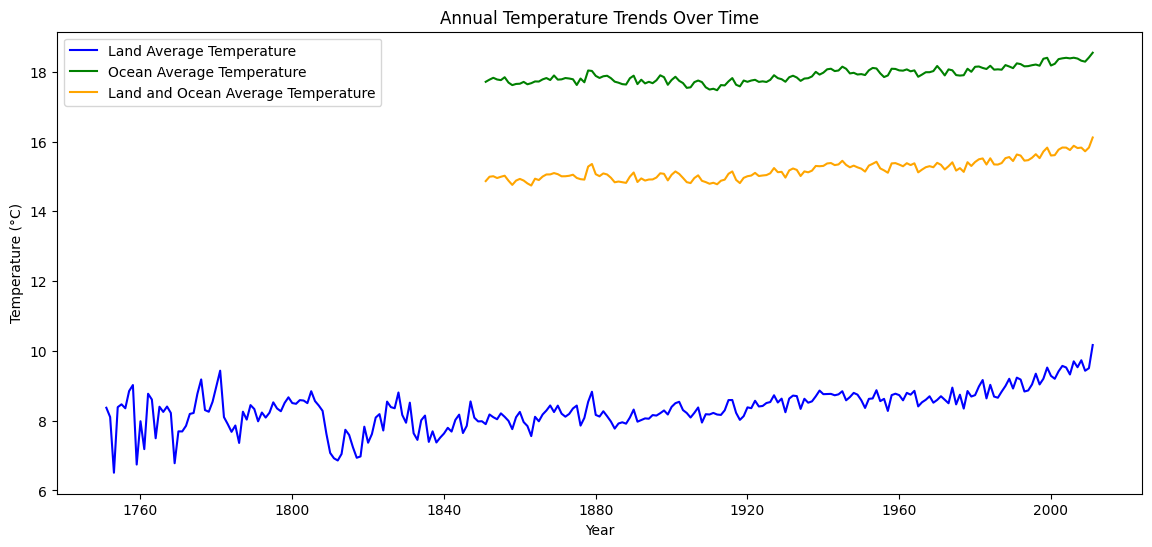

In [109]:
# Resample the data to annual frequency by taking the mean
annual_data = global_temp.resample('A').mean()

plt.figure(figsize=(14,6))
plt.plot(annual_data.index, annual_data['LandAverageTemperature'], label='Land Average Temperature', color='blue')
plt.plot(annual_data.index, annual_data['OceanAverageTemperature'], label='Ocean Average Temperature', color='green')
plt.plot(annual_data.index, annual_data['LandAndOceanAverageTemperature'], label='Land and Ocean Average Temperature', color='orange')
plt.title('Annual Temperature Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [110]:
# Reset the index so that the datetime is in a column called 'index'
global_full_reset = global_temp.reset_index()

global_full_reset.head()

,index,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,LandAverageTemperature,OceanAverageTemperature,LandAverageTemperature_Smoothed,OceanAverageTemperature_Smoothed,LandAndOceanAverageTemperature_Smoothed
0,1750-01-01,3.574,NaN,NaN,NaN,NaN,NaN,NaN,3.034,NaN,NaN,NaN,NaN
1,1750-02-01,3.702,NaN,NaN,NaN,NaN,NaN,NaN,3.083,NaN,NaN,NaN,NaN
2,1750-03-01,3.076,NaN,NaN,NaN,NaN,NaN,NaN,5.626,NaN,NaN,NaN,NaN
3,1750-04-01,2.451,NaN,NaN,NaN,NaN,NaN,NaN,8.490,NaN,NaN,NaN,NaN
4,1750-05-01,2.072,NaN,NaN,NaN,NaN,NaN,NaN,11.573,NaN,NaN,NaN,NaN


In [114]:
# Define the start date for the overlapping period
overlap_start = pd.to_datetime("1850-01-01")

# Subset the DataFrame to only include dates from the overlapping period onward
overlap_data = global_full_reset[global_full_reset['index'] >= overlap_start].copy()

# Convert dt to an ordinal number for regression purposes
overlap_data['date_ordinal'] = overlap_data['index'].map(datetime.toordinal)

In [115]:

# Prepare the feature (time) variable
X_overlap = overlap_data[['date_ordinal']]

# Define the target variables
y_land_overlap = overlap_data['LandAverageTemperature']
y_ocean_overlap = overlap_data['OceanAverageTemperature']

# Fit regression for Land Average Temperature
reg_land_overlap = LinearRegression().fit(X_overlap, y_land_overlap)
# Fit regression for Ocean Average Temperature
reg_ocean_overlap = LinearRegression().fit(X_overlap, y_ocean_overlap)

# Extract slopes (which are in °C per day)
land_slope = reg_land_overlap.coef_[0]
ocean_slope = reg_ocean_overlap.coef_[0]


In [116]:
# There are roughly 365.25 days in a year
land_rate_per_year = land_slope * 365.25
ocean_rate_per_year = ocean_slope * 365.25


In [117]:
# Calculate the difference in warming rates (land minus ocean)
rate_difference = land_rate_per_year - ocean_rate_per_year

print(f"Land warming rate (overlapping period): {land_rate_per_year:.5f} °C per year")
print(f"Ocean warming rate (overlapping period): {ocean_rate_per_year:.5f} °C per year")

if rate_difference > 0:
    print(f"Land warmed faster than the ocean by {rate_difference:.5f} °C per year.")
else:
    print(f"Ocean warmed faster than the land by {abs(rate_difference):.5f} °C per year.")


Land warming rate (overlapping period): 0.00830 °C per year
Ocean warming rate (overlapping period): 0.00381 °C per year
Land warmed faster than the ocean by 0.00449 °C per year.


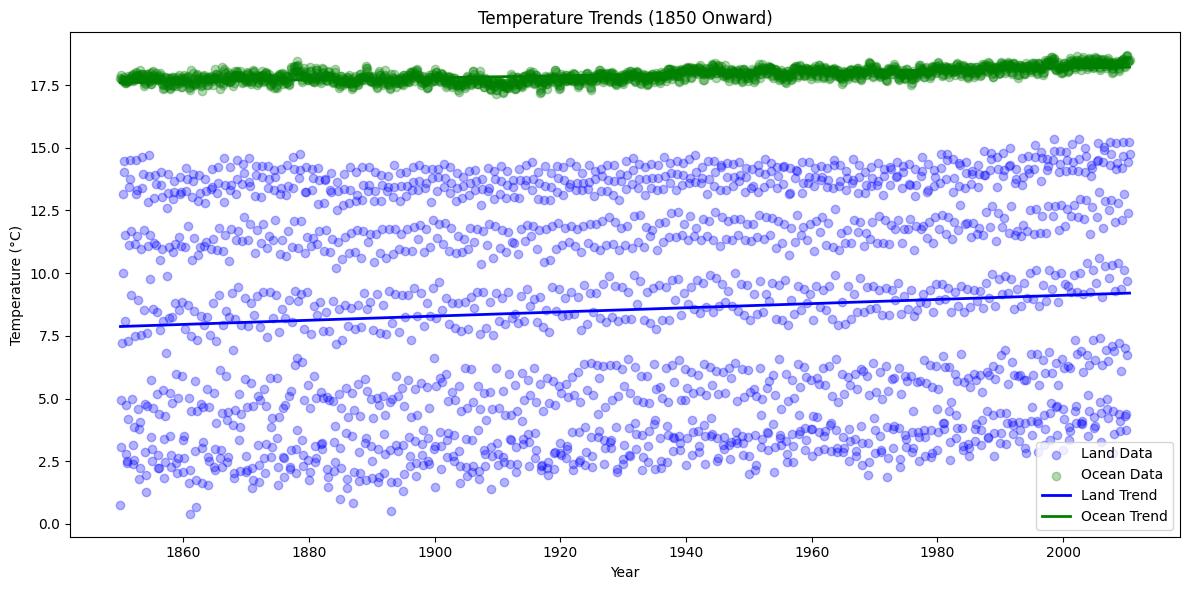

In [118]:

# Generate predicted values using the regression models
overlap_data['land_pred'] = reg_land_overlap.predict(X_overlap)
overlap_data['ocean_pred'] = reg_ocean_overlap.predict(X_overlap)

plt.figure(figsize=(12, 6))
plt.scatter(overlap_data['index'], y_land_overlap, color='blue', alpha=0.3, label='Land Data')
plt.scatter(overlap_data['index'], y_ocean_overlap, color='green', alpha=0.3, label='Ocean Data')
plt.plot(overlap_data['index'], overlap_data['land_pred'], color='blue', linewidth=2, label='Land Trend')
plt.plot(overlap_data['index'], overlap_data['ocean_pred'], color='green', linewidth=2, label='Ocean Trend')
plt.title("Temperature Trends (1850 Onward)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


In [119]:


# Extract month as a number (1-12) and month name (e.g., January, February, etc.)
global_full_reset['month'] = global_full_reset['index'].dt.month
global_full_reset['month_name'] = global_full_reset['index'].dt.strftime('%B')

In [120]:
global_full_reset.head()

,index,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,LandAverageTemperature,OceanAverageTemperature,LandAverageTemperature_Smoothed,OceanAverageTemperature_Smoothed,LandAndOceanAverageTemperature_Smoothed,month,month_name
0,1750-01-01,3.574,NaN,NaN,NaN,NaN,NaN,NaN,3.034,NaN,NaN,NaN,NaN,1,January
1,1750-02-01,3.702,NaN,NaN,NaN,NaN,NaN,NaN,3.083,NaN,NaN,NaN,NaN,2,February
2,1750-03-01,3.076,NaN,NaN,NaN,NaN,NaN,NaN,5.626,NaN,NaN,NaN,NaN,3,March
3,1750-04-01,2.451,NaN,NaN,NaN,NaN,NaN,NaN,8.490,NaN,NaN,NaN,NaN,4,April
4,1750-05-01,2.072,NaN,NaN,NaN,NaN,NaN,NaN,11.573,NaN,NaN,NaN,NaN,5,May


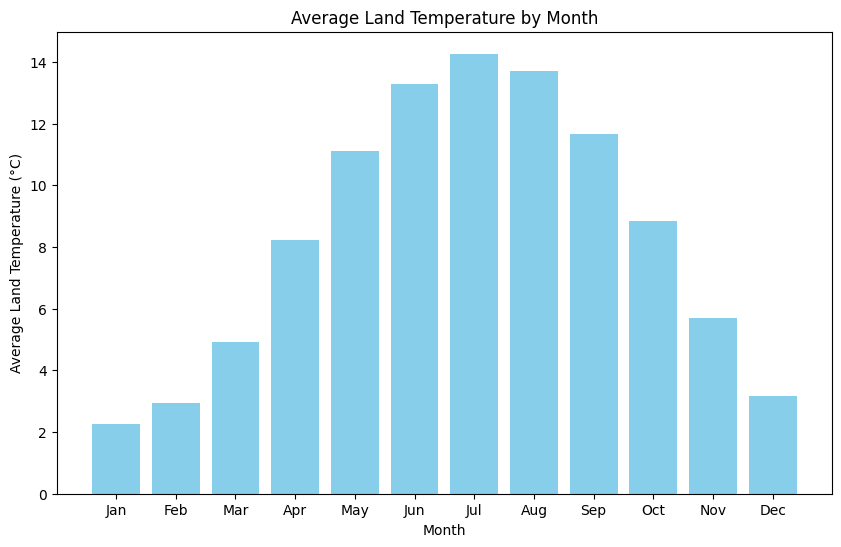

In [121]:
# Group by month (number) to get the average temperature for each month
monthly_avg = global_full_reset.groupby('month')['LandAverageTemperature'].mean()

# Create a bar plot
plt.figure(figsize=(10,6))
plt.bar(monthly_avg.index, monthly_avg.values, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Land Temperature (°C)')
plt.title('Average Land Temperature by Month')
plt.xticks(monthly_avg.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


season
Autumn     8.743004
Spring     8.091578
Summer    13.762562
Winter     2.785476
Name: LandAverageTemperature, dtype: float64


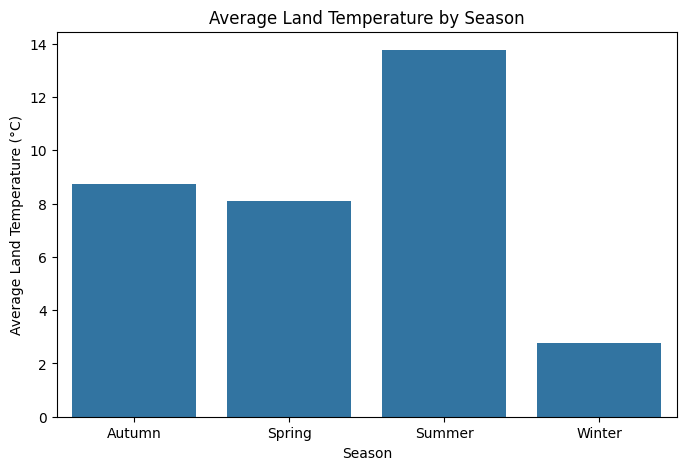

In [122]:
def assign_season(month):
    # Using Northern Hemisphere seasons as an example:
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Create a season column
global_full_reset['season'] = global_full_reset['month'].apply(assign_season)

# Group by season and calculate the average
season_avg = global_full_reset.groupby('season')['LandAverageTemperature'].mean()
print(season_avg)

# Plot average temperature by season
plt.figure(figsize=(8,5))
sns.barplot(x=['Autumn','Spring','Summer','Winter'], y=global_full_reset.groupby('season')['LandAverageTemperature'].mean().values)
plt.xlabel('Season')
plt.ylabel('Average Land Temperature (°C)')
plt.title('Average Land Temperature by Season')
plt.show()


In [123]:
country_temp_imputed.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1838-04-01,13.008000,2.586,Afghanistan
1,1838-05-01,18.389311,NaN,Afghanistan
2,1838-06-01,23.950000,2.510,Afghanistan
3,1838-07-01,26.877000,2.883,Afghanistan
4,1838-08-01,24.938000,2.992,Afghanistan


In [124]:
country_temp_imputed['date_ordinal'] = country_temp_imputed['dt'].map(datetime.toordinal)

In [125]:
country_temp_imputed.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,date_ordinal
0,1838-04-01,13.008000,2.586,Afghanistan,671041
1,1838-05-01,18.389311,NaN,Afghanistan,671071
2,1838-06-01,23.950000,2.510,Afghanistan,671102
3,1838-07-01,26.877000,2.883,Afghanistan,671132
4,1838-08-01,24.938000,2.992,Afghanistan,671163


In [126]:
def impute_temperature(group):
    # Sort the group by date
    group = group.sort_values('dt')

    # Set 'dt' as the index so that time-based interpolation can work
    group = group.set_index('dt')

    # Only interpolate if there is at least one valid value
    if group['AverageTemperature'].notna().sum() > 0:
        group['AverageTemperature'] = group['AverageTemperature'].interpolate(method='time')
        # Use forward fill then backward fill to fill edge cases
        group['AverageTemperature'] = group['AverageTemperature'].ffill().bfill()

    # Reset the index to bring 'dt' back as a column
    group = group.reset_index()

    # Create/Update the date_ordinal column
    group['date_ordinal'] = group['dt'].map(datetime.toordinal)

    # For any remaining missing values, fill with the group's mean value.
    # (If the entire group is missing, this will remain NaN; you might handle those groups separately.)
    group['AverageTemperature'] = group['AverageTemperature'].fillna(group['AverageTemperature'].mean())

    return group

# Apply the updated imputation function group-wise
country_temp_imputed_clean = country_temp_imputed.groupby('Country').apply(impute_temperature).reset_index(drop=True)

# Verify that missing values have been addressed
print(country_temp_imputed_clean['AverageTemperature'].isna().sum())


727


<ipython-input-126-08c9d30e65f5>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_temp_imputed_clean = country_temp_imputed.groupby('Country').apply(impute_temperature).reset_index(drop=True)


<ipython-input-127-64850cfe2c56>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_trends = country_temp_imputed_clean.groupby('Country').apply(compute_warming_trend)


Top 10 Countries with Fastest Warming Trends (°C per year):
Country
Oman                    0.038694
United Arab Emirates    0.030029
Pakistan                0.029846
Uzbekistan              0.028714
Turkmenistan            0.025505
China                   0.023135
Niger                   0.020392
Armenia                 0.016591
Egypt                   0.016404
Mali                    0.015518
dtype: float64


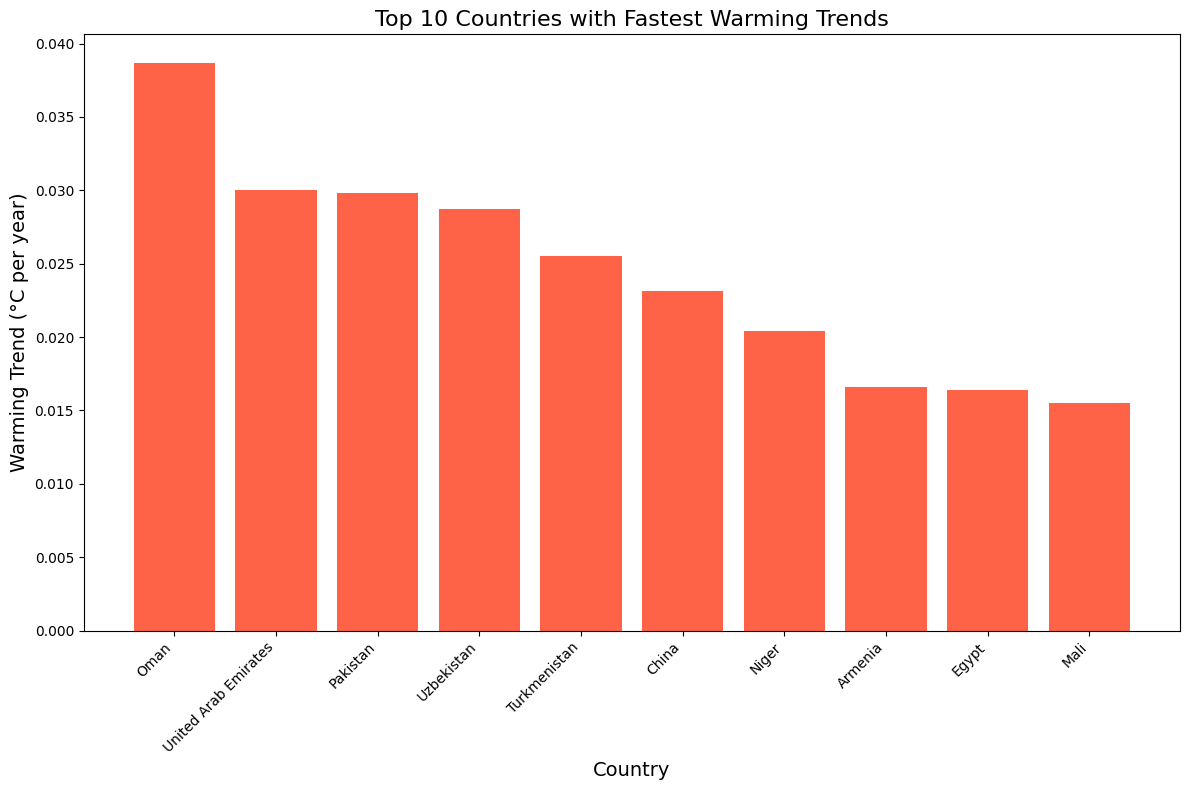

In [127]:
def compute_warming_trend(group):
    # Drop rows with missing values in 'AverageTemperature' or 'date_ordinal'
    group = group.dropna(subset=['AverageTemperature', 'date_ordinal'])

    # Optionally, skip groups with insufficient data points
    if len(group) < 10:
        return np.nan

    # Prepare the feature (time as an ordinal) and target (temperature)
    X = group[['date_ordinal']]
    y = group['AverageTemperature']

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # The slope is in °C per day; convert to °C per year
    slope_per_day = model.coef_[0]
    slope_per_year = slope_per_day * 365.25
    return slope_per_year

# Compute the warming trend for each country by grouping and applying the function.
country_trends = country_temp_imputed_clean.groupby('Country').apply(compute_warming_trend)

# Drop any countries where the trend could not be computed (e.g., groups with insufficient data)
country_trends = country_trends.dropna()

# Sort the warming trends in descending order (fastest warming at the top)
country_trends_sorted = country_trends.sort_values(ascending=False)

# Select the top 10 countries with the fastest warming trends
top_10 = country_trends_sorted.head(10)

# Print the top 10 warming trends
print("Top 10 Countries with Fastest Warming Trends (°C per year):")
print(top_10)

# Visualize the top 10 warming trends using a bar chart
plt.figure(figsize=(12,8))
plt.bar(top_10.index, top_10.values, color='tomato')
plt.xlabel('Country', fontsize=14)
plt.ylabel('Warming Trend (°C per year)', fontsize=14)
plt.title('Top 10 Countries with Fastest Warming Trends', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()